In [2]:
import sys
sys.path.append('/Users/vdk/GeneveWork/Code/calibpipe-main-calibpipe/')
from astropy.io import ascii
import numpy as np
import pandas as pd
import csv
import scipy
import matplotlib.pyplot as plt
from seaborn import histplot
import random
import copy
from os import path, makedirs
from astropy.coordinates import SkyCoord
from astropy.table import Table
import astropy.units as u
from ctapipe.containers import MuonEfficiencyContainer
from ctapipe.coordinates import CameraFrame, TelescopeFrame
from ctapipe.io import EventSource, EventSeeker
from ctapipe.core import TelescopeComponent
from ctapipe.core.traits import (
    List,
    Int,
    FloatTelescopeParameter,
    TelescopeParameter,
    Unicode,
)
from ctapipe.image.cleaning import tailcuts_clean
from ctapipe.image.muon import MuonRingFitter, MuonIntensityFitter
from traitlets.config import Config
from ctapipe.image import ImageProcessor
from ctapipe.image.muon import MuonProcessor
from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry
from ctapipe.calib import CameraCalibrator
from traitlets.config.loader import Config, FileConfigLoader, JSONFileConfigLoader
import pathlib
from calibpipe.throughput import MuonCalibrator
from traitlets.config import Config
from astropy.time import Time
from astropy.coordinates import EarthLocation,SkyCoord, AltAz 
from traitlets.config import Config
import time
from ctapipe.image import number_of_island_sizes
from ctapipe.image import (
    hillas_parameters,
    leakage_parameters,
    concentration_parameters,
)
from ctapipe.image import timing_parameters
from ctapipe.image import number_of_islands
from ctapipe.image import camera_to_shower_coordinates






### Graph for R1 cut > 2

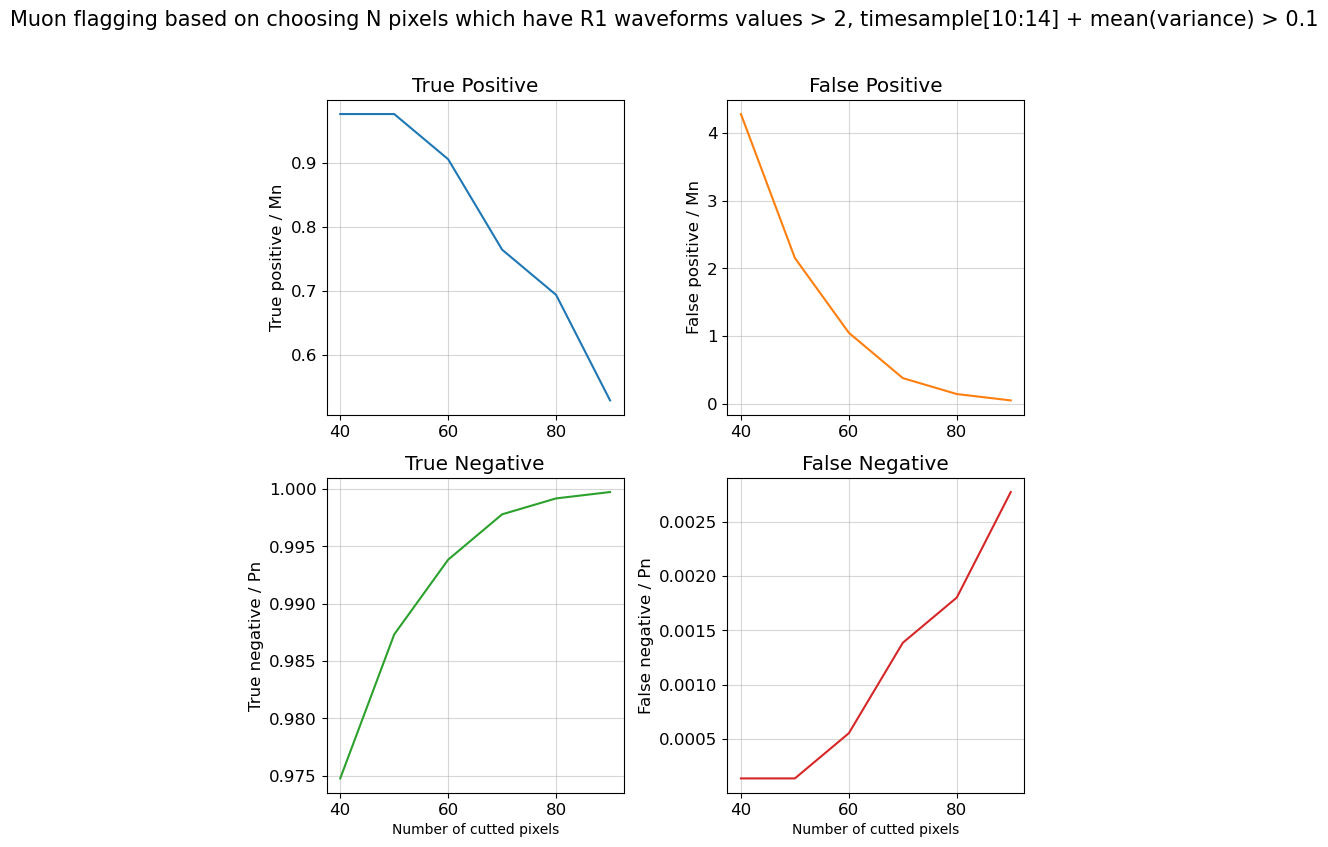

In [33]:
M_n = 85
P_n = 14517-85
cuts = np.array([40, 50, 60, 70, 80, 90])
muons_detected = np.array([85, 85, 77, 65, 59, 45])
protons_detected = np.array([838, 561, 399, 274, 205, 141]) - muons_detected
# for timeSample 10-14
#muons_detected = np.array([85, 85, 81, 66, 59, 46])
#protons_detected = np.array([616, 398, 260, 163, 120, 92]) - muons_detected
# for timeSample 10-14 + mean(variance) > 0.1
muons_detected = np.array([83, 83, 77, 65, 59, 45])
protons_detected = np.array([529, 355, 239, 154, 120, 92]) - muons_detected

# for timeSample 10-14 + mean(variance) > 0.1 and < 0.4
muons_detected = np.array([83, 83, 77, 65, 59, 45])
protons_detected = np.array([447, 266, 166, 97, 71, 49]) - muons_detected


true_negative = P_n - protons_detected
false_negative = M_n - muons_detected 
R1_cut = 2

plt.rcParams.update({'font.size': 12, 'figure.figsize': (9,9)})
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(hspace=0.2, wspace = 0.35)
fig.suptitle(f"Muon flagging based on choosing N pixels which have R1 waveforms values > {R1_cut}, timesample[10:14] + mean(variance) > 0.1", fontsize = 15)

axs[0, 0].plot(cuts, muons_detected/M_n)
axs[0, 0].set_title('True Positive')
#axs[0, 0].set_xlabel("Number of cutted pixels", fontsize = 7)
axs[0, 0].set_ylabel("True positive / Mn")

axs[0, 1].plot(cuts, (protons_detected)/M_n, 'tab:orange')
axs[0, 1].set_title('False Positive')
#axs[0, 1].set_xlabel("Number of cutted pixels", fontsize = 7)
axs[0, 1].set_ylabel("False positive / Mn")

axs[1, 0].plot(cuts, true_negative/P_n, 'tab:green')
axs[1, 0].set_title('True Negative')
axs[1, 0].set_xlabel("Number of cutted pixels", fontsize = 10)
axs[1, 0].set_ylabel("True negative / Pn")

axs[1, 1].plot(cuts, false_negative/P_n, 'tab:red')
axs[1, 1].set_title('False Negative')
axs[1, 1].set_xlabel("Number of cutted pixels", fontsize = 10)
axs[1, 1].set_ylabel("False negative / Pn")
for ax in axs.flat:
    ax.grid(alpha = 0.5)

#plt.savefig(f"/Users/vdk/ImagePurgatorium/PixelCut_R1waveform>{R1_cut}_Time+Variance.png")

precision =  [0.18568233 0.31203008 0.46385542 0.67010309 0.83098592 0.91836735]
recal =  [0.97647059 0.97647059 0.90588235 0.76470588 0.69411765 0.52941176]


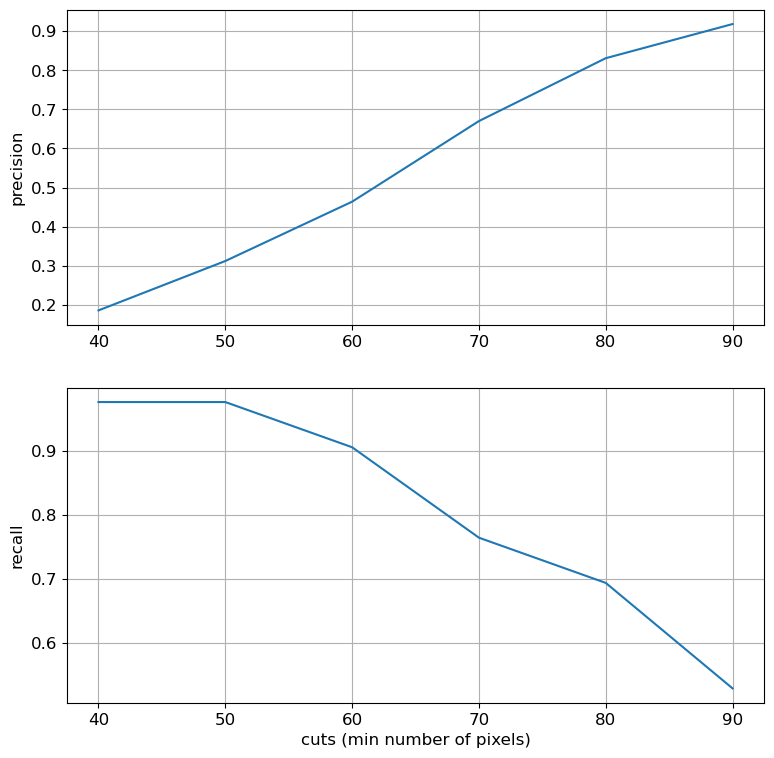

In [34]:
# PRECISION RECALL
TP = muons_detected
FP = protons_detected
TN = P_n - protons_detected
FN = M_n - muons_detected

precision = TP/(TP+FP)
recall = TP/(TP+FN)

print("precision = ", precision)
print("recal = ", recall)
#fig = plt.figure(figsize = (10,9))
_, ax = plt.subplots(2,1)

ax[0].plot(cuts, precision)
ax[0].grid()
ax[0].set_ylabel("precision")
ax[1].set_xlabel("cuts (min number of pixels)")
ax[1].plot(cuts, recall)
ax[1].set_ylabel("recall")
ax[1].grid()

### Graph for R1 cut > 3

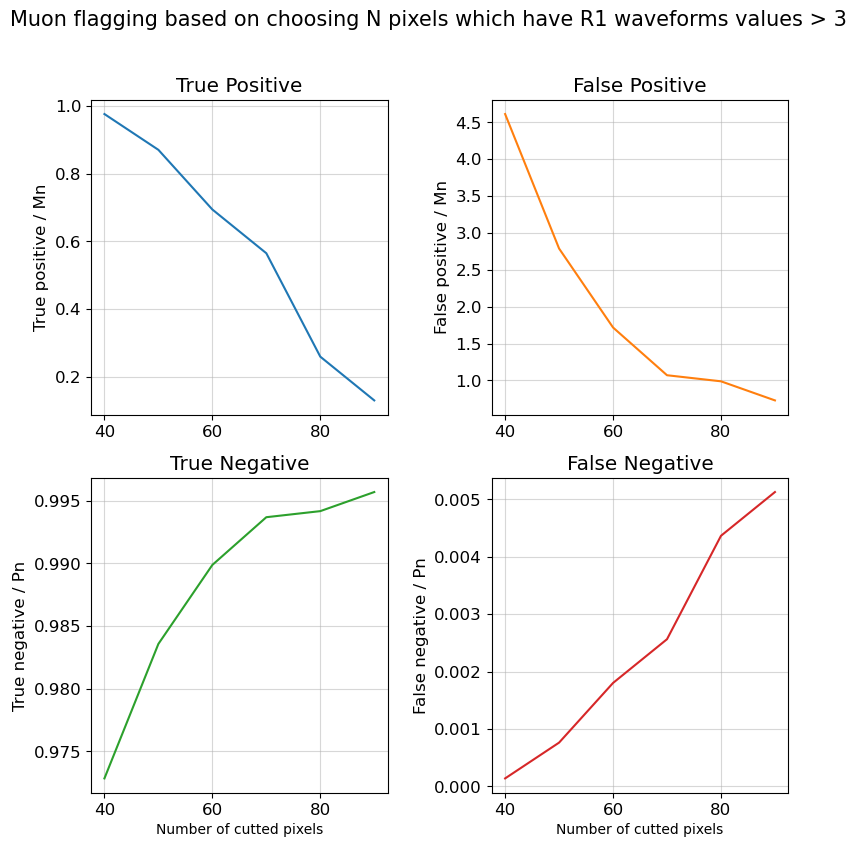

In [21]:
M_n = 85
P_n = 14517-85
cuts = np.array([40, 50, 60, 70, 80, 90])
muons_detected = np.array([83, 74, 59, 48, 22, 11])
protons_detected = np.array([475, 311, 205, 139, 106, 73]) - muons_detected
true_negative = P_n - protons_detected
false_negative = M_n - muons_detected 
R1_cut = 3

plt.rcParams.update({'font.size': 12, 'figure.figsize': (9,9)})
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(hspace=0.2, wspace = 0.35)
fig.suptitle(f"Muon flagging based on choosing N pixels which have R1 waveforms values > {R1_cut}", fontsize = 15)

axs[0, 0].plot(cuts, muons_detected/M_n)
axs[0, 0].set_title('True Positive')
#axs[0, 0].set_xlabel("Number of cutted pixels", fontsize = 7)
axs[0, 0].set_ylabel("True positive / Mn")

axs[0, 1].plot(cuts, (protons_detected)/M_n, 'tab:orange')
axs[0, 1].set_title('False Positive')
#axs[0, 1].set_xlabel("Number of cutted pixels", fontsize = 7)
axs[0, 1].set_ylabel("False positive / Mn")

axs[1, 0].plot(cuts, true_negative/P_n, 'tab:green')
axs[1, 0].set_title('True Negative')
axs[1, 0].set_xlabel("Number of cutted pixels", fontsize = 10)
axs[1, 0].set_ylabel("True negative / Pn")

axs[1, 1].plot(cuts, false_negative/P_n, 'tab:red')
axs[1, 1].set_title('False Negative')
axs[1, 1].set_xlabel("Number of cutted pixels", fontsize = 10)
axs[1, 1].set_ylabel("False negative / Pn")

for ax in axs.flat:
    ax.grid(alpha = 0.5)

#plt.savefig(f"/Users/vdk/ImagePurgatorium/PixelCut_R1waveform>{R1_cut}_V2.png")

precision =  [0.17473684 0.23794212 0.28780488 0.34532374 0.20754717 0.15068493]
recal =  [0.97647059 0.87058824 0.69411765 0.56470588 0.25882353 0.12941176]


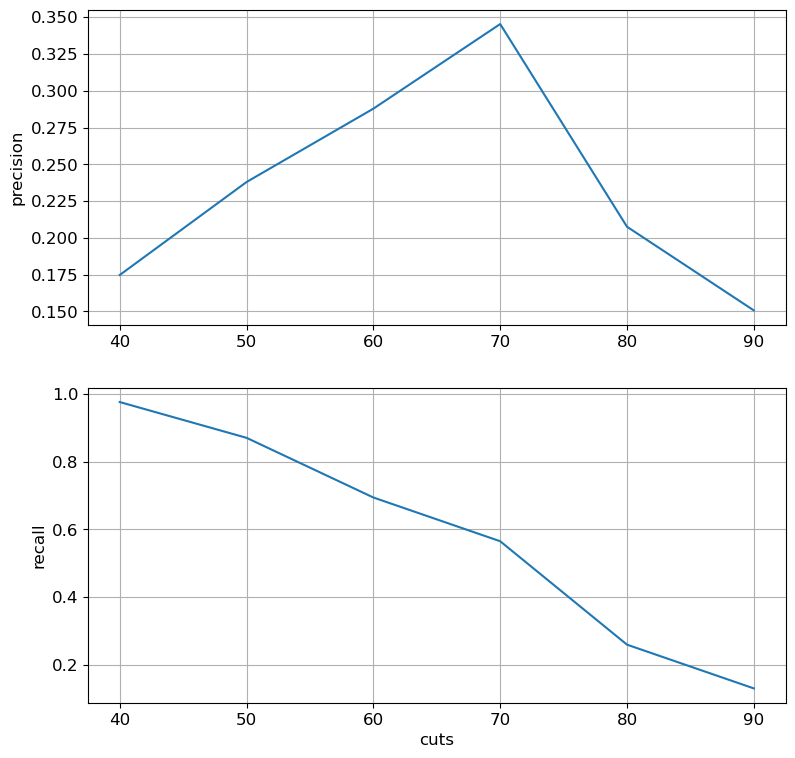

In [22]:
# PRECISION RECALL
TP = muons_detected
FP = protons_detected
TN = P_n - protons_detected
FN = M_n - muons_detected

precision = TP/(TP+FP)
recall = TP/(TP+FN)

print("precision = ", precision)
print("recal = ", recall)
#fig = plt.figure(figsize = (10,9))
_, ax = plt.subplots(2,1)

ax[0].plot(cuts, precision)
ax[0].grid()
ax[0].set_ylabel("precision")
ax[1].set_xlabel("cuts")
ax[1].plot(cuts, recall)
ax[1].set_ylabel("recall")
ax[1].grid()

### Graph for R1 cut > 4

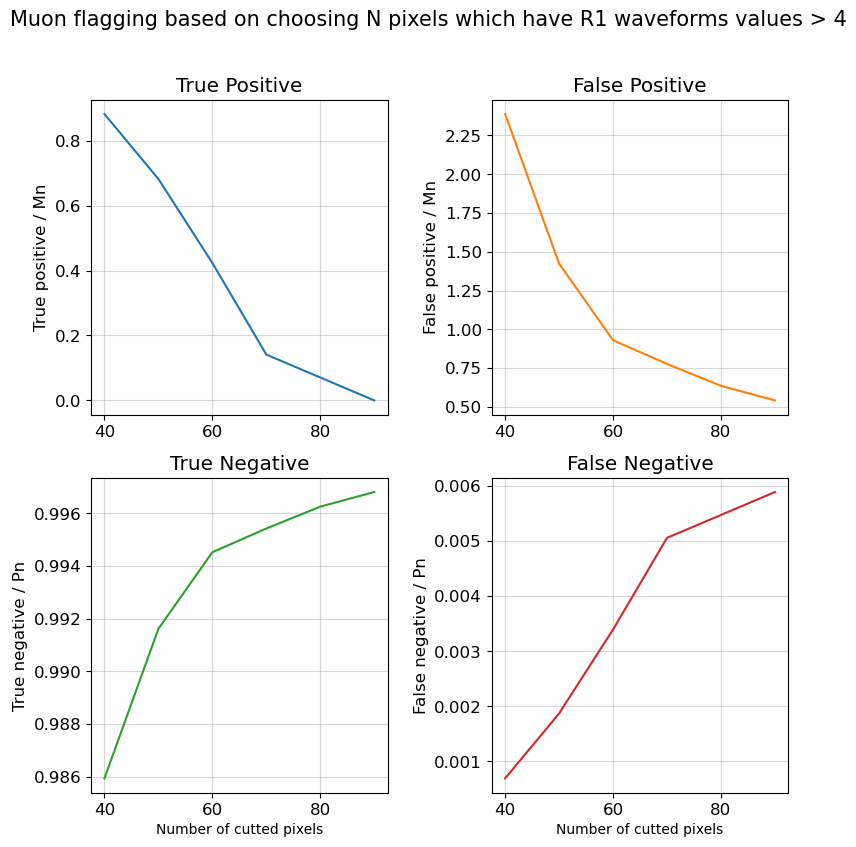

In [14]:
M_n = 85
P_n = 14517-85
cuts = np.array([40, 50, 60, 70, 80, 90])
muons_detected = np.array([75, 58, 36, 12, 6,0])
protons_detected = np.array([278, 179, 115, 78, 60, 46]) - muons_detected
true_negative = P_n - protons_detected
false_negative = M_n - muons_detected 
R1_cut = 4

plt.rcParams.update({'font.size': 12, 'figure.figsize': (9,9)})
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(hspace=0.2, wspace = 0.35)
fig.suptitle(f"Muon flagging based on choosing N pixels which have R1 waveforms values > {R1_cut}", fontsize = 15)

axs[0, 0].plot(cuts, muons_detected/M_n)
axs[0, 0].set_title('True Positive')
#axs[0, 0].set_xlabel("Number of cutted pixels", fontsize = 7)
axs[0, 0].set_ylabel("True positive / Mn")

axs[0, 1].plot(cuts, (protons_detected)/M_n, 'tab:orange')
axs[0, 1].set_title('False Positive')
#axs[0, 1].set_xlabel("Number of cutted pixels", fontsize = 7)
axs[0, 1].set_ylabel("False positive / Mn")

axs[1, 0].plot(cuts, true_negative/P_n, 'tab:green')
axs[1, 0].set_title('True Negative')
axs[1, 0].set_xlabel("Number of cutted pixels", fontsize = 10)
axs[1, 0].set_ylabel("True negative / Pn")

axs[1, 1].plot(cuts, false_negative/P_n, 'tab:red')
axs[1, 1].set_title('False Negative')
axs[1, 1].set_xlabel("Number of cutted pixels", fontsize = 10)
axs[1, 1].set_ylabel("False negative / Pn")

for ax in axs.flat:
    ax.grid(alpha = 0.5)

#plt.savefig(f"/Users/vdk/ImagePurgatorium/PixelCut_R1waveform>{R1_cut}_V2.png")

precision =  [0.26978417 0.32402235 0.31304348 0.15384615 0.1        0.        ]
recal =  [0.88235294 0.68235294 0.42352941 0.14117647 0.07058824 0.        ]


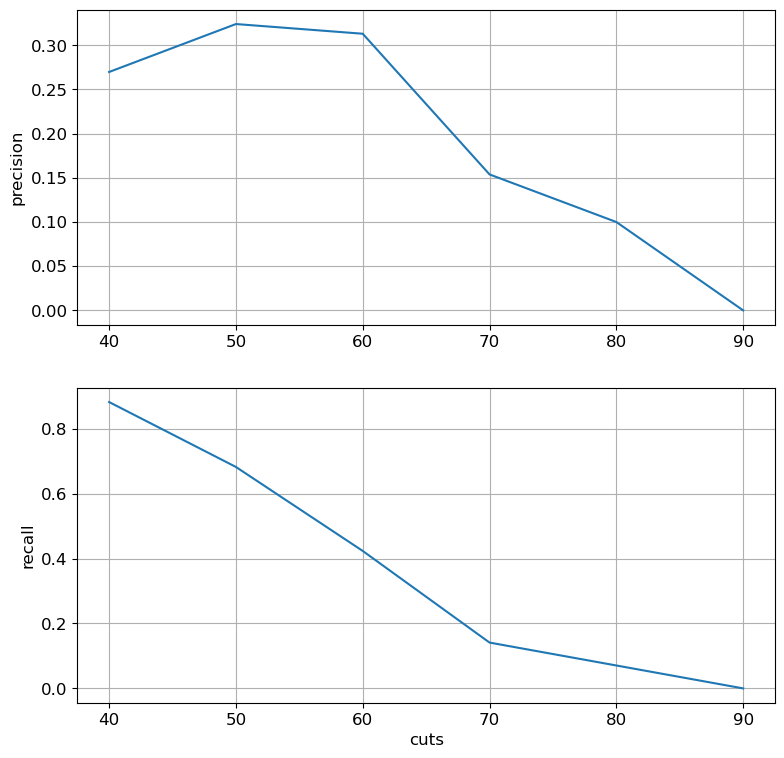

In [15]:
# PRECISION RECALL
TP = muons_detected
FP = protons_detected
TN = P_n - protons_detected
FN = M_n - muons_detected

precision = TP/(TP+FP)
recall = TP/(TP+FN)

print("precision = ", precision)
print("recal = ", recall)
#fig = plt.figure(figsize = (10,9))
_, ax = plt.subplots(2,1)

ax[0].plot(cuts, precision)
ax[0].grid()
ax[0].set_ylabel("precision")
ax[1].set_xlabel("cuts")
ax[1].plot(cuts, recall)
ax[1].set_ylabel("recall")
ax[1].grid()

### Graph for R1 cut > 5

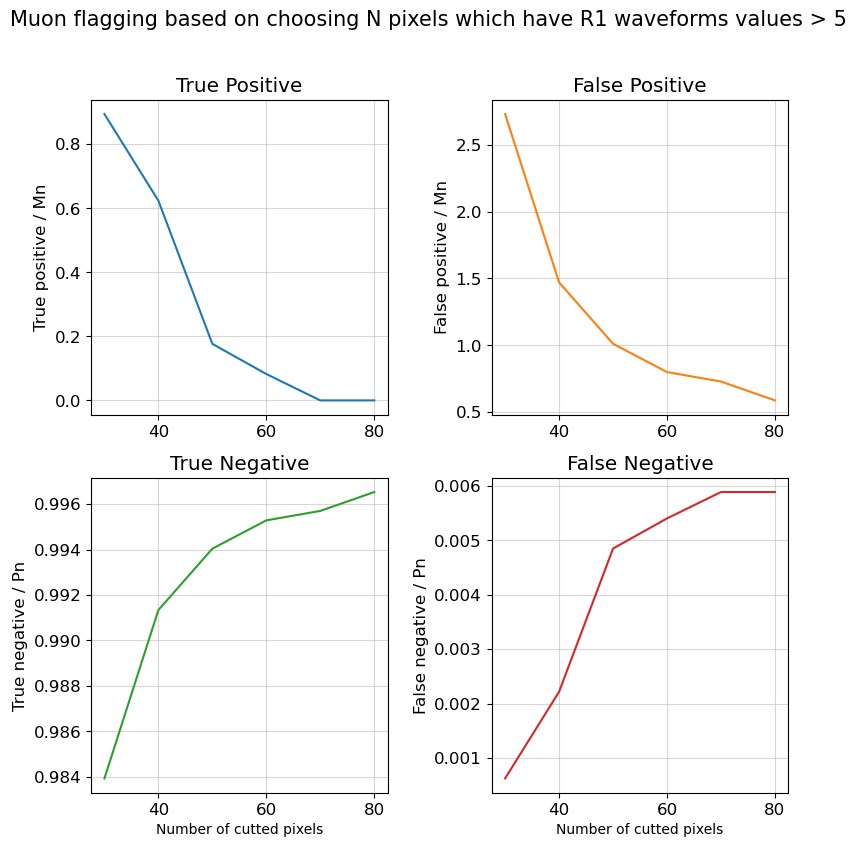

In [18]:
M_n = 85
P_n = 14517-85
cuts = np.array([30, 40, 50, 60, 70, 80])
muons_detected = np.array([76, 53, 15, 7, 0,0])
protons_detected = np.array([308, 178, 101, 75, 62,50]) - muons_detected
true_negative = P_n - protons_detected
false_negative = M_n - muons_detected 
R1_cut = 5

plt.rcParams.update({'font.size': 12, 'figure.figsize': (9,9)})
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(hspace=0.2, wspace = 0.35)
fig.suptitle(f"Muon flagging based on choosing N pixels which have R1 waveforms values > {R1_cut}", fontsize = 15)

axs[0, 0].plot(cuts, muons_detected/M_n)
axs[0, 0].set_title('True Positive')
#axs[0, 0].set_xlabel("Number of cutted pixels", fontsize = 7)
axs[0, 0].set_ylabel("True positive / Mn")

axs[0, 1].plot(cuts, (protons_detected)/M_n, 'tab:orange')
axs[0, 1].set_title('False Positive')
#axs[0, 1].set_xlabel("Number of cutted pixels", fontsize = 7)
axs[0, 1].set_ylabel("False positive / Mn")

axs[1, 0].plot(cuts, true_negative/P_n, 'tab:green')
axs[1, 0].set_title('True Negative')
axs[1, 0].set_xlabel("Number of cutted pixels", fontsize = 10)
axs[1, 0].set_ylabel("True negative / Pn")

axs[1, 1].plot(cuts, false_negative/P_n, 'tab:red')
axs[1, 1].set_title('False Negative')
axs[1, 1].set_xlabel("Number of cutted pixels", fontsize = 10)
axs[1, 1].set_ylabel("False negative / Pn")

for ax in axs.flat:
    ax.grid(alpha = 0.5)

#plt.savefig(f"/Users/vdk/ImagePurgatorium/PixelCut_R1waveform>{R1_cut}_V2.png")

precision =  [0.24675325 0.29775281 0.14851485 0.09333333 0.         0.        ]
recal =  [0.89411765 0.62352941 0.17647059 0.08235294 0.         0.        ]


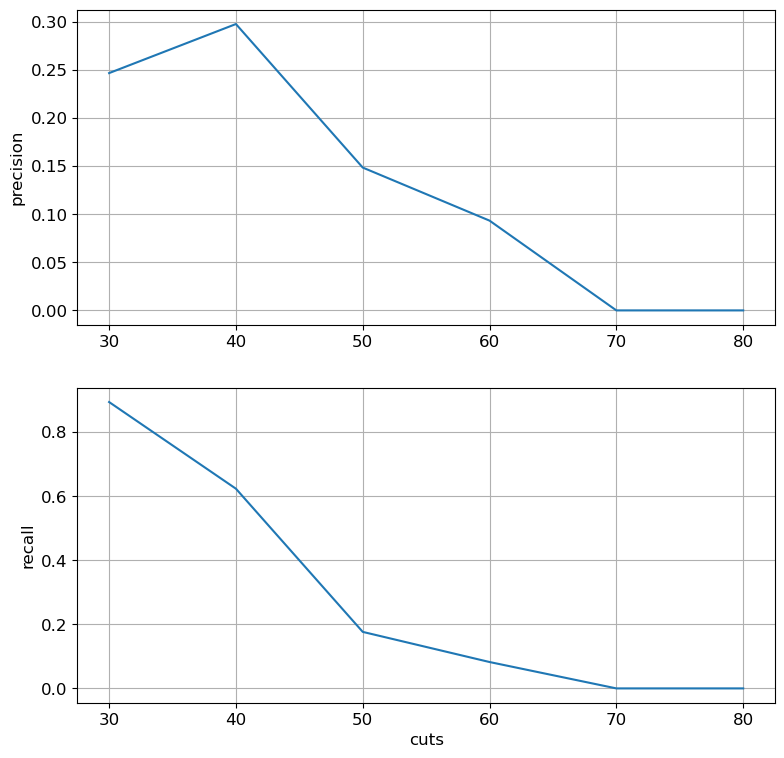

In [19]:
# PRECISION RECALL
TP = muons_detected
FP = protons_detected
TN = P_n - protons_detected
FN = M_n - muons_detected

precision = TP/(TP+FP)
recall = TP/(TP+FN)

print("precision = ", precision)
print("recal = ", recall)
#fig = plt.figure(figsize = (10,9))
_, ax = plt.subplots(2,1)

ax[0].plot(cuts, precision)
ax[0].grid()
ax[0].set_ylabel("precision")
ax[1].set_xlabel("cuts")
ax[1].plot(cuts, recall)
ax[1].set_ylabel("recall")
ax[1].grid()

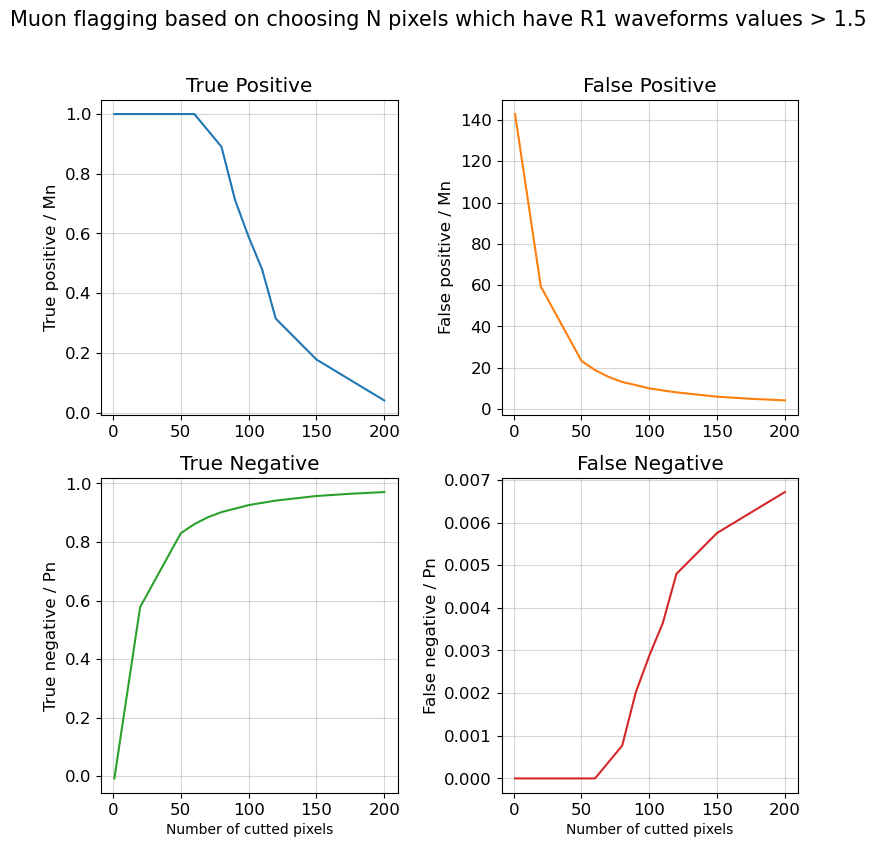

In [22]:
M_n = 73
P_n = 10423
cuts = np.array([1, 20, 50, 60, 70, 80, 90, 100, 110, 120, 150, 175, 200])
muons_detected = np.array([73, 73, 73, 73, 69, 65, 52, 43, 35, 23, 13, 8, 3])
protons_detected = np.array([10501, 4403, 1773, 1449, 1204, 1021, 897, 772, 691, 612, 448, 369, 307])
true_negative = P_n - protons_detected
false_negative = M_n - muons_detected 
R1_cut = 1.5

plt.rcParams.update({'font.size': 12, 'figure.figsize': (9,9)})
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(hspace=0.2, wspace = 0.35)
fig.suptitle(f"Muon flagging based on choosing N pixels which have R1 waveforms values > {R1_cut}", fontsize = 15)

axs[0, 0].plot(cuts, muons_detected/M_n)
axs[0, 0].set_title('True Positive')
#axs[0, 0].set_xlabel("Number of cutted pixels", fontsize = 7)
axs[0, 0].set_ylabel("True positive / Mn")

axs[0, 1].plot(cuts, (protons_detected-muons_detected)/M_n, 'tab:orange')
axs[0, 1].set_title('False Positive')
#axs[0, 1].set_xlabel("Number of cutted pixels", fontsize = 7)
axs[0, 1].set_ylabel("False positive / Mn")

axs[1, 0].plot(cuts, true_negative/P_n, 'tab:green')
axs[1, 0].set_title('True Negative')
axs[1, 0].set_xlabel("Number of cutted pixels", fontsize = 10)
axs[1, 0].set_ylabel("True negative / Pn")

axs[1, 1].plot(cuts, false_negative/P_n, 'tab:red')
axs[1, 1].set_title('False Negative')
axs[1, 1].set_xlabel("Number of cutted pixels", fontsize = 10)
axs[1, 1].set_ylabel("False negative / Pn")


#for ax in axs.flat:
#    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()
for ax in axs.flat:
    ax.grid(alpha = 0.5)

#plt.savefig(f"/Users/vdk/ImagePurgatorium/PixelCut_R1waveform>{R1_cut}_V2.png")

precision =  [0.18568233 0.31203008 0.46385542 0.67010309 0.83098592 0.91836735]
recal =  [0.97647059 0.97647059 0.90588235 0.76470588 0.69411765 0.52941176]


Text(0, 0.5, 'Precision')

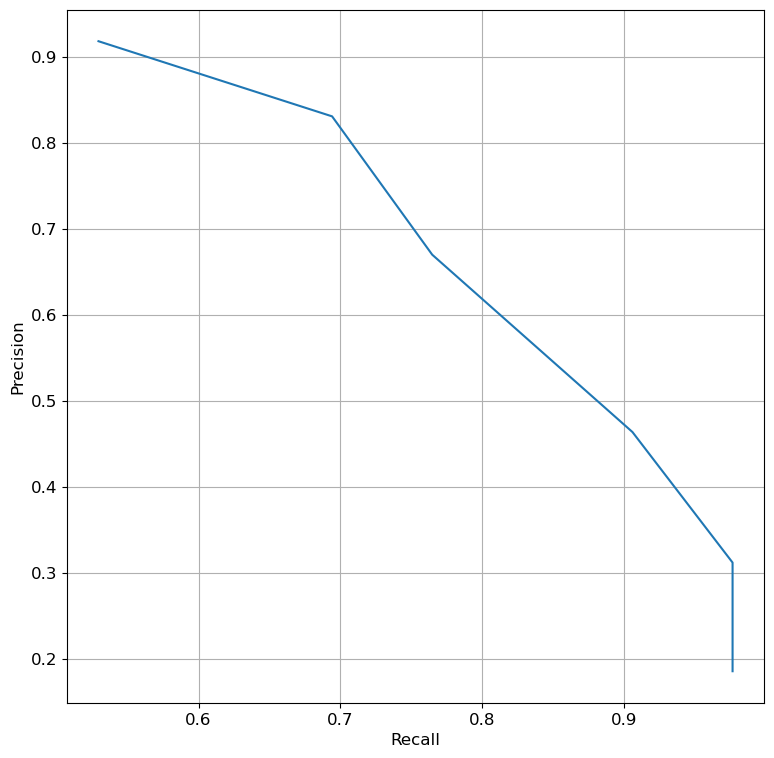

In [19]:
# PRECISION RECALL
TP = muons_detected
FP = protons_detected
TN = P_n - protons_detected
FN = M_n - muons_detected

precision = TP/(TP+FP)
recall = TP/(TP+FN)

print("precision = ", precision)
print("recal = ", recall)

plt.plot(recall, precision)
plt.grid()
plt.xlabel("Recall")
plt.ylabel("Precision")

In [2]:
plt.plot(wave_sum, muon_number/proton_number)
plt.ylabel("muons / (muons+protons)")
plt.xlabel("r1.waveform.sum()")

NameError: name 'wave_sum' is not defined

In [6]:
muon_number = np.array([3,9,11,12,12,12])
rev
proton_number = np.array([185,209, 250,295, 323, 365])
wave_sum = np.array([600,500,400,300,250,200])

NameError: name 'rev' is not defined

In [ ]:
plt.plot(wave_sum, muon_number/proton_number*100)
plt.grid(alpha = 0.5)
plt.ylabel("muons / protons [%]")
plt.xlabel("Number of active pixels (r1 waveform amplitude > 1.2)")
plt.title("Dependence of relative number of muon rings from number of active pixels")

In [ ]:
plt.plot(muon_number, proton_number)
plt.ylabel("Protons (false positive)")
plt.title("Fraction of muon rings to the overall number of events flagged as muon rings")
plt.xlabel("Muon rings (true positive)")
plt.grid(alpha = 0.5)

In [ ]:
threshold = np.array([1, 1.2, 1.5, 1.7, 2])
rings = np.array([38, 36, 33, 27, 16])
protons = np.array([692, 583, 492, 443, 375])

In [ ]:
plt.plot(threshold, rings/protons)
plt.ylabel("Protons (false positive)")
plt.title("Fraction of muon rings to the overall number of events flagged as muon rings")
plt.xlabel("Muon rings (true positive)")
plt.grid(alpha = 0.5)

In [ ]:
plt.plot(rings, protons)
plt.ylabel("Protons (false positive)")
plt.title("Fraction of muon rings to the overall number of events flagged as muon rings")
plt.xlabel("Muon rings (true positive)")
plt.grid(alpha = 0.5)

In [ ]:
plt.plot(muon_number/9320, proton_number/9320)
plt.ylabel("Protons (false positive)")
plt.title("Fraction of muon rings to the overall number of events flagged as muon rings")
plt.xlabel("Muon rings (true positive)")
plt.grid(alpha = 0.5)

In [ ]:
fp_rate = (proton_number-muon_number) / ((9320-proton_number) + (proton_number - muon_number))
fp_rate

In [7]:
Mn = 73
Pn = 10427
TP = muon_number/Mn
FP = proton_number/Mn

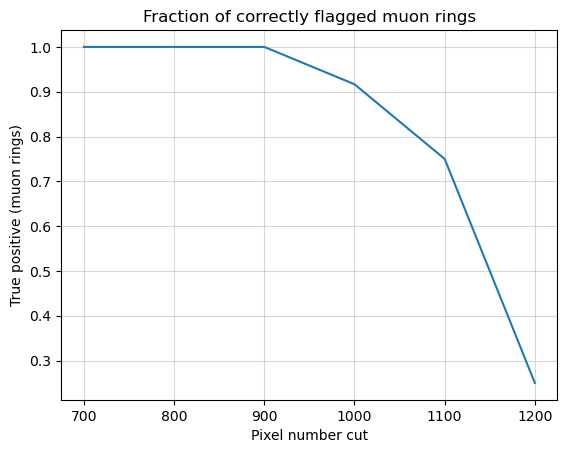

In [8]:
plt.plot(np.flip(wave_sum),(np.flip(muon_number)/Mn))
plt.ylabel("True positive (muon rings)")
plt.title("Fraction of correctly flagged muon rings")
plt.xlabel("Pixel number cut")
plt.grid(alpha = 0.5)

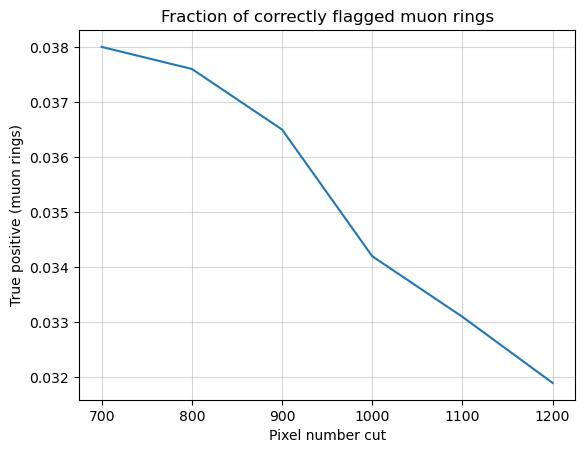

In [9]:
plt.plot(np.flip(wave_sum),(np.flip(proton_number)/Pn))
plt.ylabel("True positive (muon rings)")
plt.title("Fraction of correctly flagged muon rings")
plt.xlabel("Pixel number cut")
plt.grid(alpha = 0.5)

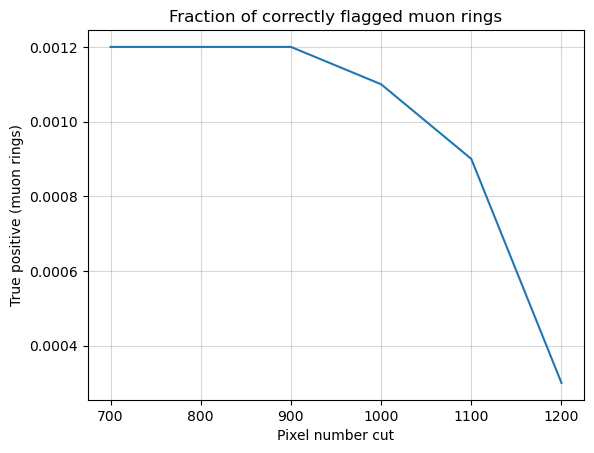

In [10]:
plt.plot(np.flip(wave_sum),(np.flip(muon_number)/Pn))
plt.ylabel("True positive (muon rings)")
plt.title("Fraction of correctly flagged muon rings")
plt.xlabel("Pixel number cut")
plt.grid(alpha = 0.5)

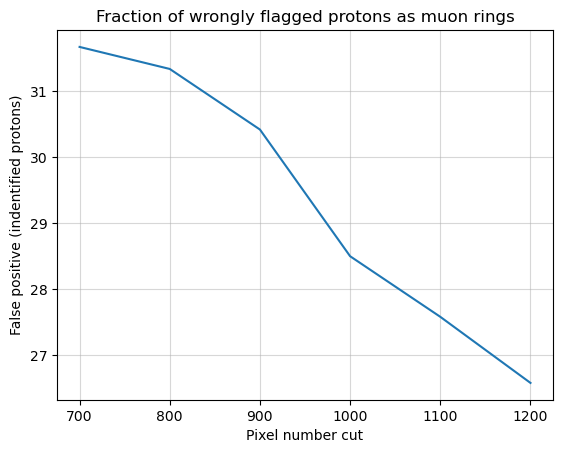

In [11]:
plt.plot(np.flip(wave_sum),(np.flip(proton_number)/Mn))
plt.ylabel("False positive (indentified protons)")
plt.title("Fraction of wrongly flagged protons as muon rings")
plt.xlabel("Pixel number cut")
plt.grid(alpha = 0.5)

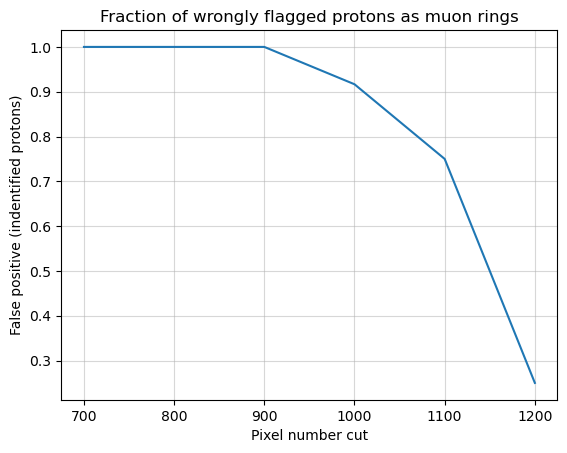

In [12]:
plt.plot(np.flip(wave_sum),(np.flip(muon_number)/Mn))
plt.ylabel("False positive (indentified protons)")
plt.title("Fraction of wrongly flagged protons as muon rings")
plt.xlabel("Pixel number cut")
plt.grid(alpha = 0.5)

In [4]:
# HERE GOOD CALCULATIONS

cuts = np.array([1,50, 70, 100, 150, 175, 200, 225, 250, 275, 300, 350, 400, 450])
M_n = 73
P_n = 10427
muons_detected = np.array([73, 73, 73, 73, 71, 68, 63, 60, 50, 40, 30, 19, 15, 11])
protons_detected = np.array([10427, 3811, 2873, 2125, 1542, 1356, 1214, 1113, 999, 904, 834, 735, 671, 601])
true_negative = P_n - protons_detected
false_negative = M_n - muons_detected 


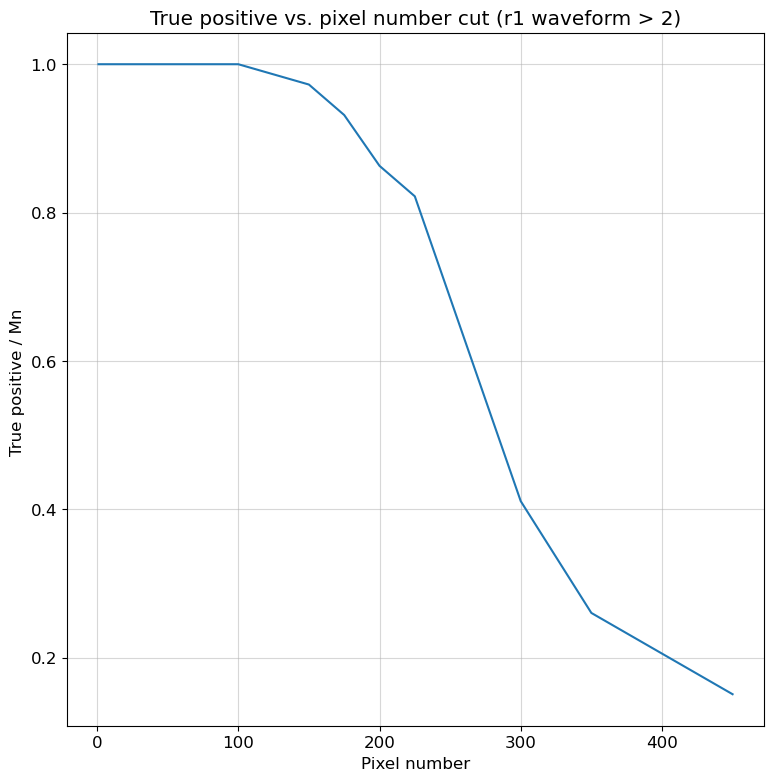

In [78]:
plt.plot(cuts, muons_detected/M_n)

plt.ylabel("True positive / Mn ")
plt.title("True positive vs. pixel number cut (r1 waveform > 2)")
plt.xlabel("Pixel number")
plt.grid(alpha = 0.5)

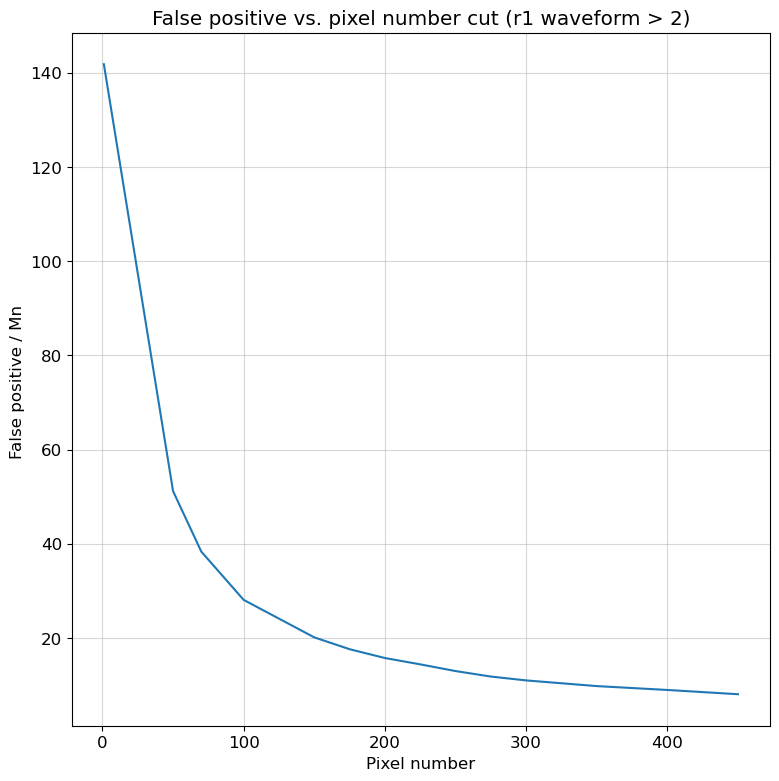

In [79]:
plt.plot(cuts, (protons_detected-muons_detected)/M_n)
plt.ylabel("False positive / Mn ")
plt.title("False positive vs. pixel number cut (r1 waveform > 2)")
plt.xlabel("Pixel number")
plt.grid(alpha = 0.5)

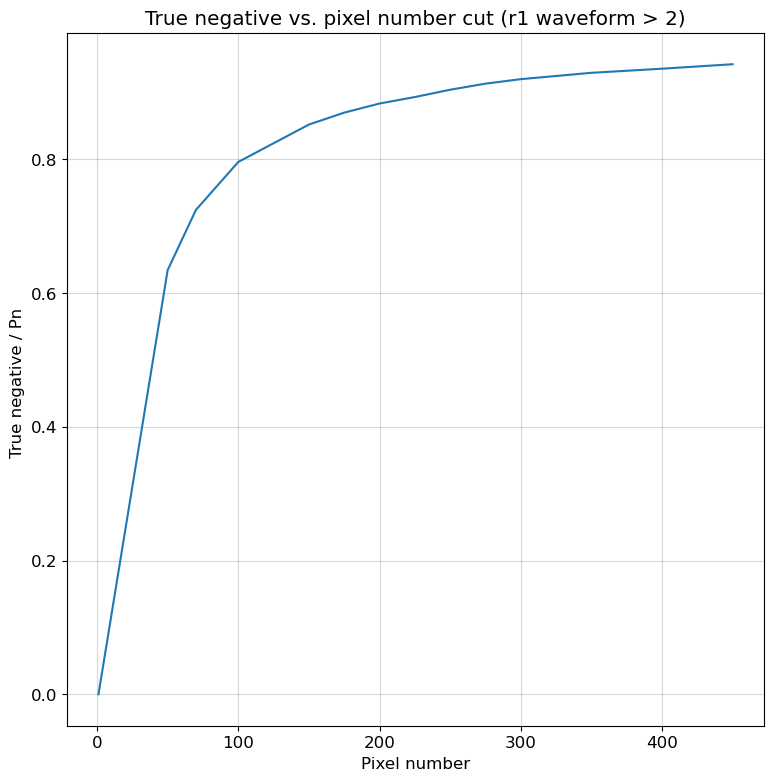

In [80]:
plt.plot(cuts, true_negative/P_n)
plt.ylabel("True negative / Pn ")
plt.title("True negative vs. pixel number cut (r1 waveform > 2)")
plt.xlabel("Pixel number")
plt.grid(alpha = 0.5)

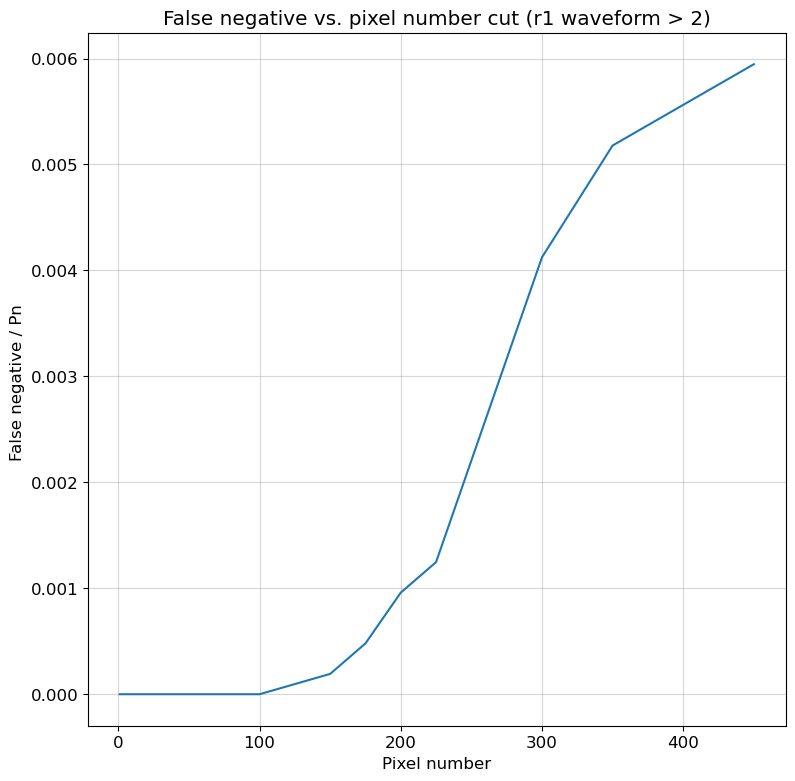

In [81]:
plt.plot(cuts, false_negative/P_n)
plt.ylabel("False negative / Pn ")
plt.title("False negative vs. pixel number cut (r1 waveform > 2)")
plt.xlabel("Pixel number")
plt.grid(alpha = 0.5)

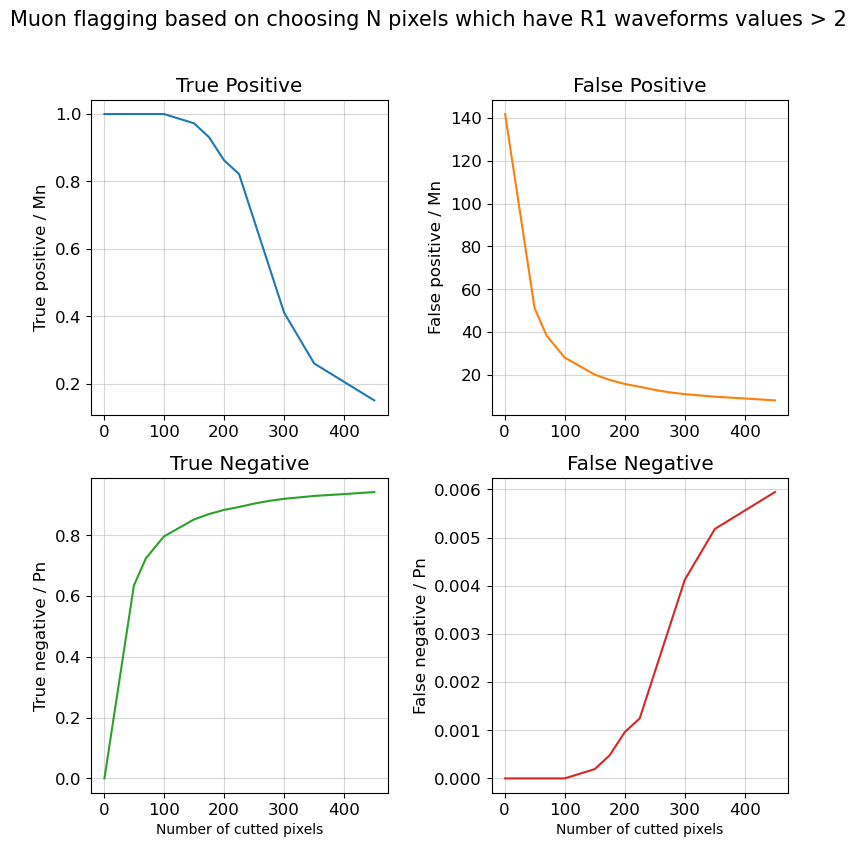

In [4]:
cuts = np.array([1,50, 70, 100, 150, 175, 200, 225, 250, 275, 300, 350, 400, 450])
M_n = 73
P_n = 10427
muons_detected = np.array([73, 73, 73, 73, 71, 68, 63, 60, 50, 40, 30, 19, 15, 11])
protons_detected = np.array([10427, 3811, 2873, 2125, 1542, 1356, 1214, 1113, 999, 904, 834, 735, 671, 601])
true_negative = P_n - protons_detected
false_negative = M_n - muons_detected 

plt.rcParams.update({'font.size': 12, 'figure.figsize': (9,9)})
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(hspace=0.2, wspace = 0.35)
fig.suptitle("Muon flagging based on choosing N pixels which have R1 waveforms values > 2", fontsize = 15)

axs[0, 0].plot(cuts, muons_detected/M_n)
axs[0, 0].set_title('True Positive')
#axs[0, 0].set_xlabel("Number of cutted pixels", fontsize = 7)
axs[0, 0].set_ylabel("True positive / Mn")

axs[0, 1].plot(cuts, (protons_detected-muons_detected)/M_n, 'tab:orange')
axs[0, 1].set_title('False Positive')
#axs[0, 1].set_xlabel("Number of cutted pixels", fontsize = 7)
axs[0, 1].set_ylabel("False positive / Mn")

axs[1, 0].plot(cuts, true_negative/P_n, 'tab:green')
axs[1, 0].set_title('True Negative')
axs[1, 0].set_xlabel("Number of cutted pixels", fontsize = 10)
axs[1, 0].set_ylabel("True negative / Pn")

axs[1, 1].plot(cuts, false_negative/P_n, 'tab:red')
axs[1, 1].set_title('False Negative')
axs[1, 1].set_xlabel("Number of cutted pixels", fontsize = 10)
axs[1, 1].set_ylabel("False negative / Pn")


#for ax in axs.flat:
#    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()
for ax in axs.flat:
    ax.grid(alpha = 0.5)

#plt.savefig("/Users/vdk/ImagePurgatorium/PixelCut_R1waveform>2_V2.png")

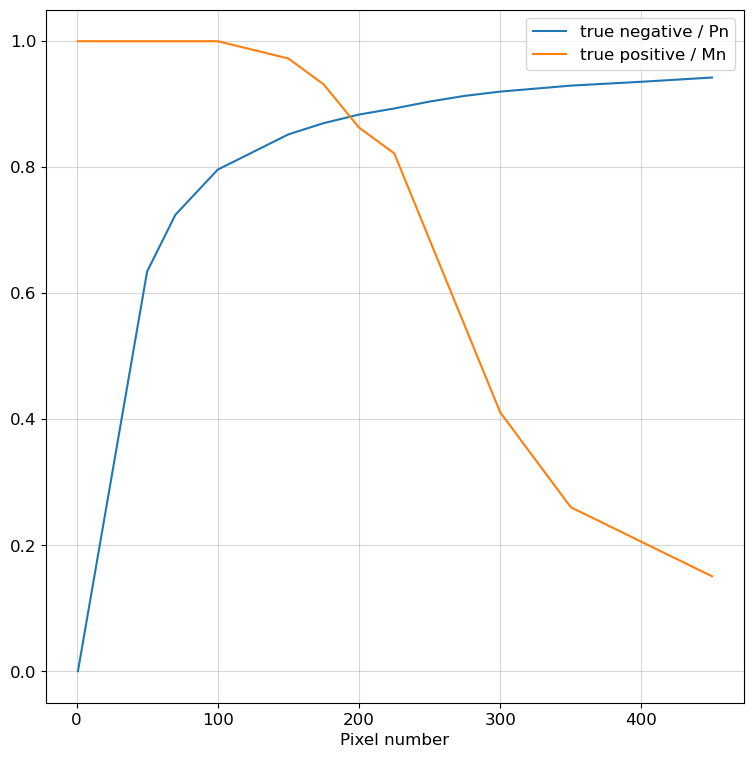

In [87]:
plt.plot(cuts, true_negative/P_n, label = "true negative / Pn")
plt.plot(cuts, muons_detected/M_n,  label = "true positive / Mn")
#plt.ylabel("True positive / Mn ")
#plt.title("True positive vs. pixel number cut (r1 waveform > 2)")
plt.xlabel("Pixel number")
plt.grid(alpha = 0.5)
#plt.ylabel("True negative / Pn ")
#plt.title("True negative vs. pixel number cut (r1 waveform > 2)")
#plt.xlabel("Pixel number")
plt.grid(alpha = 0.5)
plt.legend()

In [70]:
arr1 = [2414, 3211, 3403, 4426, 6200, 6317, 6466, 7418, 8234, 8448, 9404, 9433, 12262, 12334, 14335, 14402, 15185, 15405, 19103, 20229, 20402, 21288, 21433, 22053, 22205, 22271, 22390, 23382, 24482, 26113, 26164, 26347, 26365, 27176, 27374, 28000, 28034, 28328, 29266, 29390, 30405, 30462, 31176, 31386, 32064, 32298, 33057, 33071, 35052, 35219, 35375, 35435, 36231, 36364, 36452, 37363, 39094, 39152, 39376]
arr2 = [2414, 3211, 4426, 6200, 7418, 12334, 14335, 15185, 15405, 22053, 22271, 23382, 24482, 28034, 30405, 30462, 36364, 37363, 39094, 39152, 39376]
arr3 = [1018, 1018, 1149, 1321, 1389, 2363, 2414, 3198, 3211, 3403, 4426, 5363, 5425, 6200, 6317, 6376, 6376, 6417, 6419, 6466, 7176, 7418, 8234, 8316, 8323, 8369, 8448, 8473, 8487, 8490, 9318, 9404, 9433, 9435, 9444, 9486, 12061, 12162, 12262, 12305, 12334, 13320, 14214, 14335, 14390, 14402, 15185, 15196, 15405, 15447, 16213, 16471, 17000, 17168, 17168, 18137, 18291, 18476, 19103, 20120, 20229, 20356, 20402, 21281, 21288, 21433, 22053, 22053, 22123, 22205, 22271, 22354, 22364, 22390, 23382, 23419, 24294, 24482, 24482, 25051, 25345, 26113, 26164, 26336, 26338, 26347, 26365, 26374, 27176, 27281, 27374, 27414, 28000, 28034, 28328, 28341, 28357, 28372, 29213, 29266, 29372, 29390, 30181, 30291, 30405, 30447, 30462, 31042, 31043, 31123, 31176, 31332, 31332, 31333, 31386, 32064, 32256, 32298, 33057, 33071, 34115, 35052, 35103, 35219, 35296, 35375, 35376, 35393, 35435, 35444, 35472, 36231, 36364, 36452, 37363, 39083, 39094, 39152, 39376, 39401, 39444, 39466]

len(arr1) - len(arr2)

38

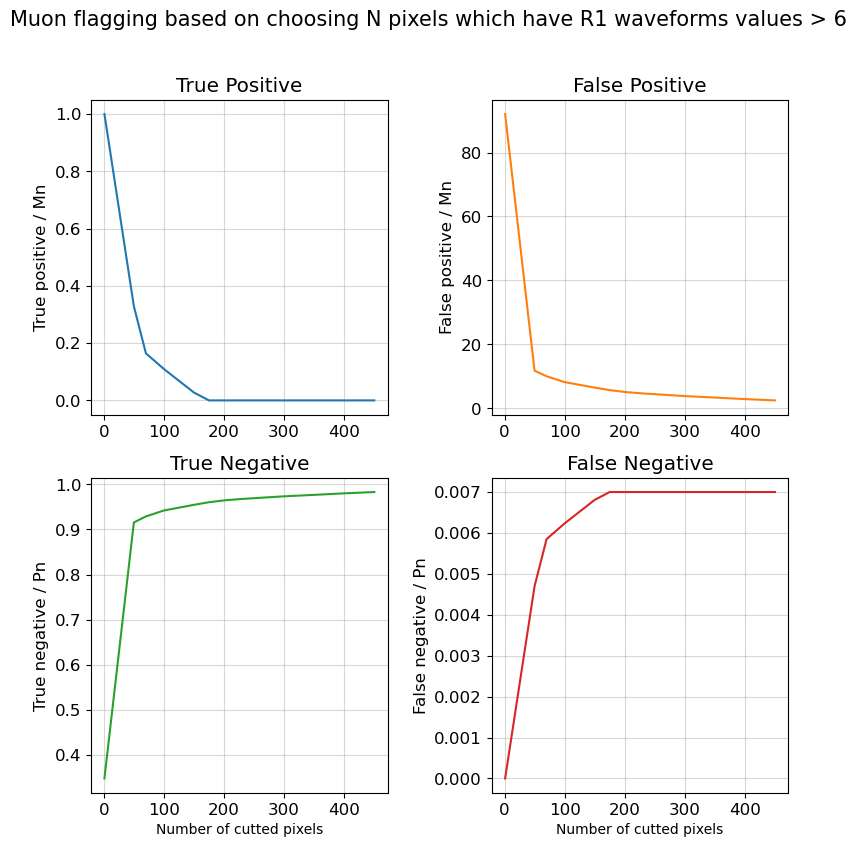

In [12]:
cuts = np.array([1,50, 70, 100, 150, 175, 200, 225, 250, 275, 300, 350, 400, 450])
muons_detected = np.array([73, 24, 12, 8, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0])
protons_detected = np.array([6792, 881, 742, 605, 474, 414, 372, 343, 321, 299, 278, 244, 209, 179])
true_negative = P_n - protons_detected
false_negative = M_n - muons_detected 

plt.rcParams.update({'font.size': 12, 'figure.figsize': (9,9)})
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(hspace=0.2, wspace = 0.35)
fig.suptitle("Muon flagging based on choosing N pixels which have R1 waveforms values > 6", fontsize = 15)

axs[0, 0].plot(cuts, muons_detected/M_n)
axs[0, 0].set_title('True Positive')
#axs[0, 0].set_xlabel("Number of cutted pixels", fontsize = 7)
axs[0, 0].set_ylabel("True positive / Mn")

axs[0, 1].plot(cuts, (protons_detected-muons_detected)/M_n, 'tab:orange')
axs[0, 1].set_title('False Positive')
#axs[0, 1].set_xlabel("Number of cutted pixels", fontsize = 7)
axs[0, 1].set_ylabel("False positive / Mn")

axs[1, 0].plot(cuts, true_negative/P_n, 'tab:green')
axs[1, 0].set_title('True Negative')
axs[1, 0].set_xlabel("Number of cutted pixels", fontsize = 10)
axs[1, 0].set_ylabel("True negative / Pn")

axs[1, 1].plot(cuts, false_negative/P_n, 'tab:red')
axs[1, 1].set_title('False Negative')
axs[1, 1].set_xlabel("Number of cutted pixels", fontsize = 10)
axs[1, 1].set_ylabel("False negative / Pn")


#for ax in axs.flat:
#    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()
for ax in axs.flat:
    ax.grid(alpha = 0.5)

#plt.savefig("/Users/vdk/ImagePurgatorium/PixelCut_R1waveform>6_V2.png")

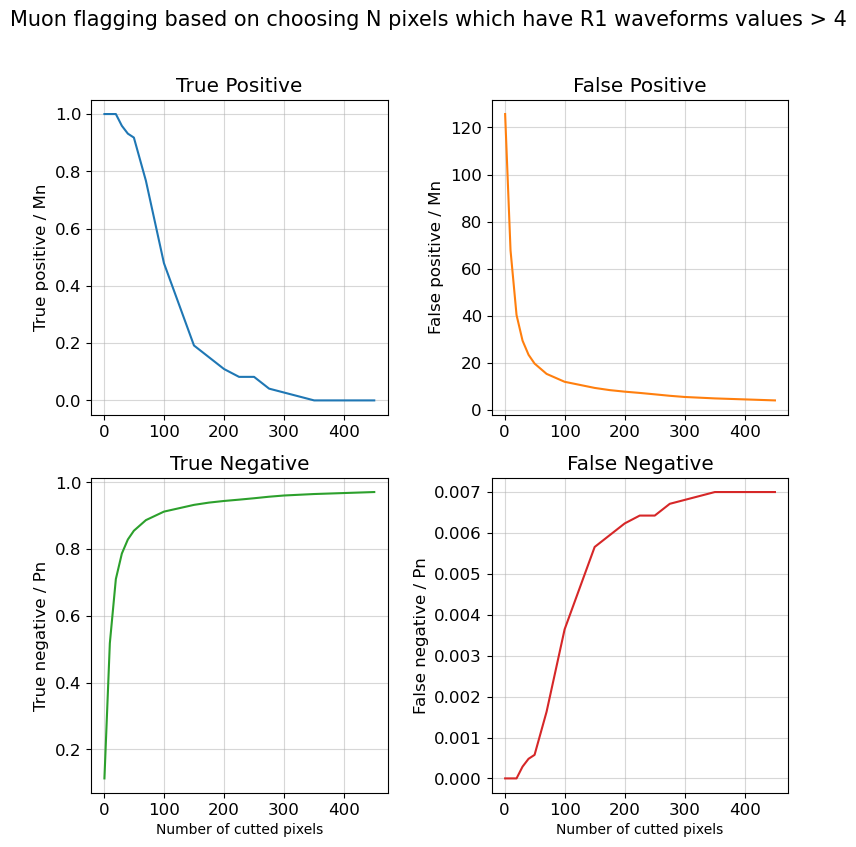

In [16]:
cuts = np.array([1, 10, 20, 30, 40, 50, 70, 100, 150, 175, 200, 225, 250, 275, 300, 350, 450])
muons_detected = np.array([73, 73, 73, 70, 68, 67, 56, 35, 14, 11, 8, 6, 6, 3, 2, 0, 0])
protons_detected = np.array([9248, 5023, 3019, 2221, 1781, 1508, 1177, 911, 700, 629, 578, 537, 493, 445, 407, 361, 299])
true_negative = P_n - protons_detected
false_negative = M_n - muons_detected 

plt.rcParams.update({'font.size': 12, 'figure.figsize': (9,9)})
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(hspace=0.2, wspace = 0.35)
fig.suptitle("Muon flagging based on choosing N pixels which have R1 waveforms values > 4", fontsize = 15)

axs[0, 0].plot(cuts, muons_detected/M_n)
axs[0, 0].set_title('True Positive')
#axs[0, 0].set_xlabel("Number of cutted pixels", fontsize = 7)
axs[0, 0].set_ylabel("True positive / Mn")

axs[0, 1].plot(cuts, (protons_detected-muons_detected)/M_n, 'tab:orange')
axs[0, 1].set_title('False Positive')
#axs[0, 1].set_xlabel("Number of cutted pixels", fontsize = 7)
axs[0, 1].set_ylabel("False positive / Mn")

axs[1, 0].plot(cuts, true_negative/P_n, 'tab:green')
axs[1, 0].set_title('True Negative')
axs[1, 0].set_xlabel("Number of cutted pixels", fontsize = 10)
axs[1, 0].set_ylabel("True negative / Pn")

axs[1, 1].plot(cuts, false_negative/P_n, 'tab:red')
axs[1, 1].set_title('False Negative')
axs[1, 1].set_xlabel("Number of cutted pixels", fontsize = 10)
axs[1, 1].set_ylabel("False negative / Pn")


#for ax in axs.flat:
#    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()
for ax in axs.flat:
    ax.grid(alpha = 0.5)

#plt.savefig("/Users/vdk/ImagePurgatorium/PixelCut_R1waveform>4_V2.png")

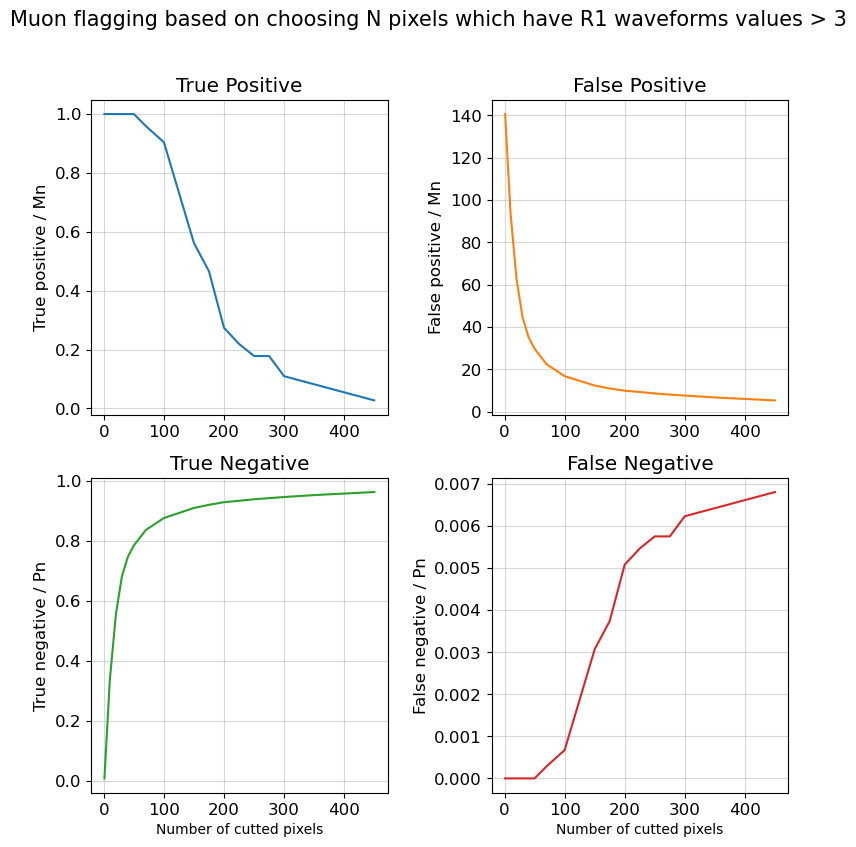

In [6]:
cuts = np.array([1, 10, 20, 30, 40, 50, 70, 100, 150, 175, 200, 225, 250, 275, 300, 350, 450])
muons_detected = np.array([73, 73, 73, 73, 73, 73, 70, 66, 41, 34, 20, 16, 13, 13, 8, 6,2])
protons_detected = np.array([10342, 6919, 4652, 3332, 2641, 2247, 1709, 1294, 945, 836, 744, 696, 643, 604, 565, 498,392])
true_negative = P_n - protons_detected
false_negative = M_n - muons_detected 
R1_cut = 3

plt.rcParams.update({'font.size': 12, 'figure.figsize': (9,9)})
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(hspace=0.2, wspace = 0.35)
fig.suptitle(f"Muon flagging based on choosing N pixels which have R1 waveforms values > {R1_cut}", fontsize = 15)

axs[0, 0].plot(cuts, muons_detected/M_n)
axs[0, 0].set_title('True Positive')
#axs[0, 0].set_xlabel("Number of cutted pixels", fontsize = 7)
axs[0, 0].set_ylabel("True positive / Mn")

axs[0, 1].plot(cuts, (protons_detected-muons_detected)/M_n, 'tab:orange')
axs[0, 1].set_title('False Positive')
#axs[0, 1].set_xlabel("Number of cutted pixels", fontsize = 7)
axs[0, 1].set_ylabel("False positive / Mn")

axs[1, 0].plot(cuts, true_negative/P_n, 'tab:green')
axs[1, 0].set_title('True Negative')
axs[1, 0].set_xlabel("Number of cutted pixels", fontsize = 10)
axs[1, 0].set_ylabel("True negative / Pn")

axs[1, 1].plot(cuts, false_negative/P_n, 'tab:red')
axs[1, 1].set_title('False Negative')
axs[1, 1].set_xlabel("Number of cutted pixels", fontsize = 10)
axs[1, 1].set_ylabel("False negative / Pn")


#for ax in axs.flat:
#    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()
for ax in axs.flat:
    ax.grid(alpha = 0.5)

#plt.savefig(f"/Users/vdk/ImagePurgatorium/PixelCut_R1waveform>{R1_cut}_V2.png")

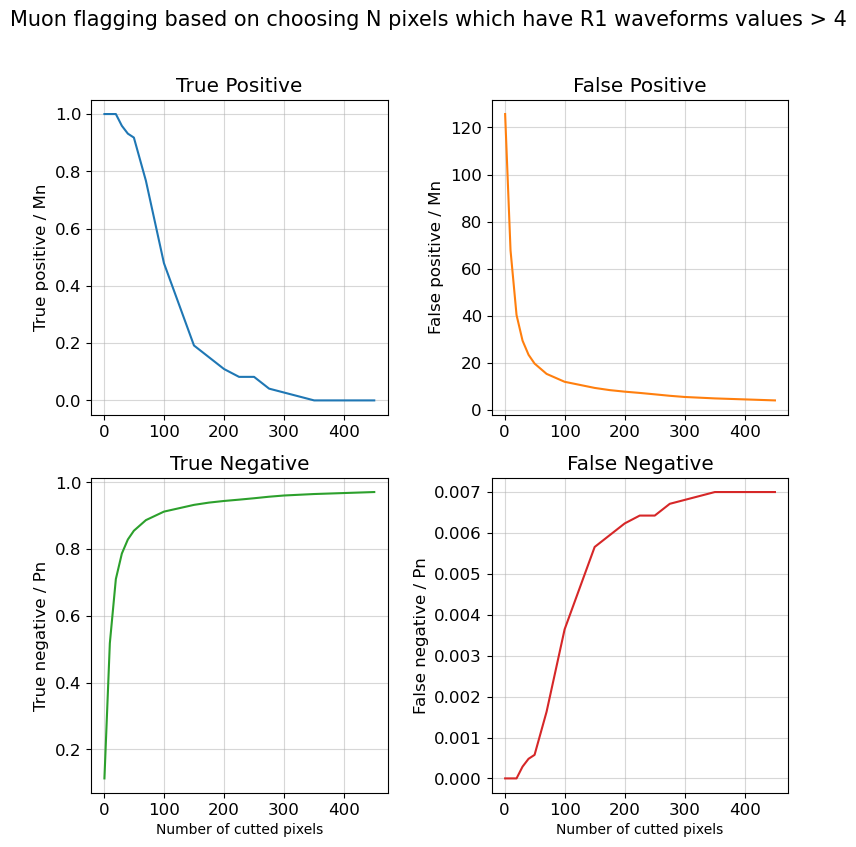

In [8]:
cuts = np.array([1, 10, 20, 30, 40, 50, 70, 100, 150, 175, 200, 225, 250, 275, 300, 350, 450])
muons_detected = np.array([73, 73, 73, 70, 68, 67, 56, 35, 14, 11, 8, 6, 6, 3, 2, 0, 0])
protons_detected = np.array([9248, 5023, 3019, 2221, 1781, 1508, 1177, 911, 700, 629, 578, 537, 493, 445, 407, 361, 299])
true_negative = P_n - protons_detected
false_negative = M_n - muons_detected 
R1_cut = 4

plt.rcParams.update({'font.size': 12, 'figure.figsize': (9,9)})
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(hspace=0.2, wspace = 0.35)
fig.suptitle(f"Muon flagging based on choosing N pixels which have R1 waveforms values > {R1_cut}", fontsize = 15)

axs[0, 0].plot(cuts, muons_detected/M_n)
axs[0, 0].set_title('True Positive')
#axs[0, 0].set_xlabel("Number of cutted pixels", fontsize = 7)
axs[0, 0].set_ylabel("True positive / Mn")

axs[0, 1].plot(cuts, (protons_detected-muons_detected)/M_n, 'tab:orange')
axs[0, 1].set_title('False Positive')
#axs[0, 1].set_xlabel("Number of cutted pixels", fontsize = 7)
axs[0, 1].set_ylabel("False positive / Mn")

axs[1, 0].plot(cuts, true_negative/P_n, 'tab:green')
axs[1, 0].set_title('True Negative')
axs[1, 0].set_xlabel("Number of cutted pixels", fontsize = 10)
axs[1, 0].set_ylabel("True negative / Pn")

axs[1, 1].plot(cuts, false_negative/P_n, 'tab:red')
axs[1, 1].set_title('False Negative')
axs[1, 1].set_xlabel("Number of cutted pixels", fontsize = 10)
axs[1, 1].set_ylabel("False negative / Pn")


#for ax in axs.flat:
#    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()
for ax in axs.flat:
    ax.grid(alpha = 0.5)

#plt.savefig(f"/Users/vdk/ImagePurgatorium/PixelCut_R1waveform>{R1_cut}_V2.png")

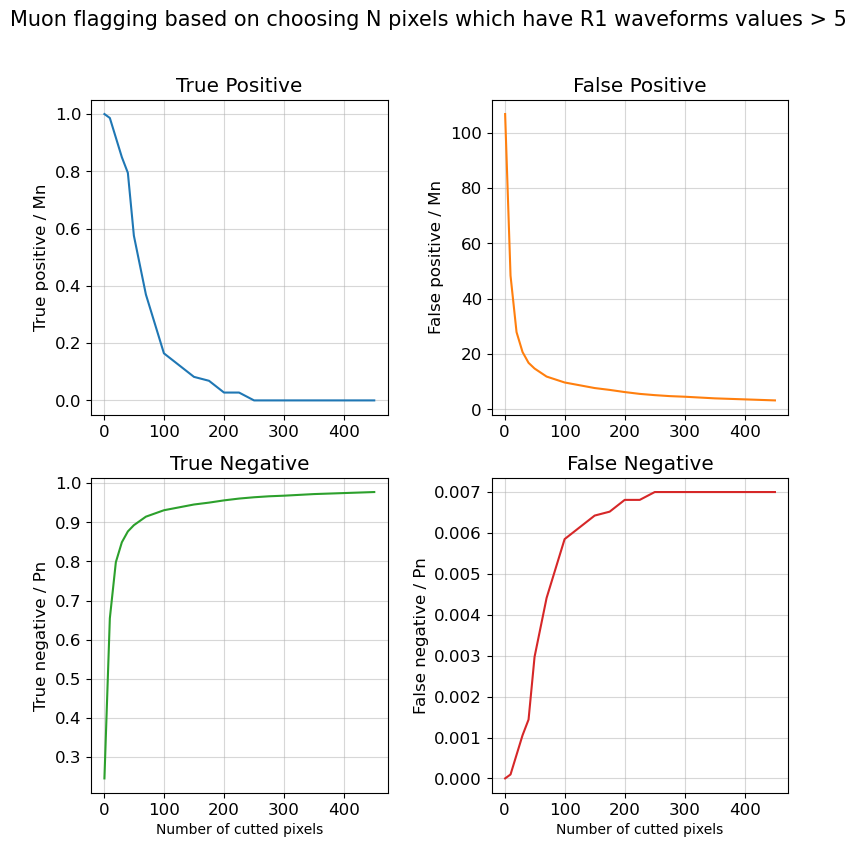

In [10]:
cuts = np.array([1, 10, 20, 30, 40, 50, 70, 100, 150, 175, 200, 225, 250, 275, 300, 350, 450])
muons_detected = np.array([73, 72, 67, 62, 58, 42, 27, 12, 6, 5, 2, 2, 0, 0, 0, 0, 0])
protons_detected = np.array([7866, 3601, 2106, 1575, 1286, 1120, 893, 722, 569, 519, 459, 411, 376, 350, 334, 291, 237])
true_negative = P_n - protons_detected
false_negative = M_n - muons_detected 
R1_cut = 5

plt.rcParams.update({'font.size': 12, 'figure.figsize': (9,9)})
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(hspace=0.2, wspace = 0.35)
fig.suptitle(f"Muon flagging based on choosing N pixels which have R1 waveforms values > {R1_cut}", fontsize = 15)

axs[0, 0].plot(cuts, muons_detected/M_n)
axs[0, 0].set_title('True Positive')
#axs[0, 0].set_xlabel("Number of cutted pixels", fontsize = 7)
axs[0, 0].set_ylabel("True positive / Mn")

axs[0, 1].plot(cuts, (protons_detected-muons_detected)/M_n, 'tab:orange')
axs[0, 1].set_title('False Positive')
#axs[0, 1].set_xlabel("Number of cutted pixels", fontsize = 7)
axs[0, 1].set_ylabel("False positive / Mn")

axs[1, 0].plot(cuts, true_negative/P_n, 'tab:green')
axs[1, 0].set_title('True Negative')
axs[1, 0].set_xlabel("Number of cutted pixels", fontsize = 10)
axs[1, 0].set_ylabel("True negative / Pn")

axs[1, 1].plot(cuts, false_negative/P_n, 'tab:red')
axs[1, 1].set_title('False Negative')
axs[1, 1].set_xlabel("Number of cutted pixels", fontsize = 10)
axs[1, 1].set_ylabel("False negative / Pn")


#for ax in axs.flat:
#    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()
for ax in axs.flat:
    ax.grid(alpha = 0.5)

#plt.savefig(f"/Users/vdk/ImagePurgatorium/PixelCut_R1waveform>{R1_cut}_V2.png")

In [3]:
cuts = np.array([1, 10, 20, 30, 50, 70, 100, 150, 175, 200, 225, 250, 275, 300, 325, 350, 450])
muons_detected = np.array([73, 66, 57, 40, 24, 12, 8, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0 ])
protons_detected = np.array([6792, 2562, 1549, 1187, 881, 742, 605, 474, 414, 372, 343, 321, 299, 278, 244, 209, 179])
true_negative = P_n - protons_detected
false_negative = M_n - muons_detected 
R1_cut = 6

plt.rcParams.update({'font.size': 12, 'figure.figsize': (9,9)})
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(hspace=0.2, wspace = 0.35)
fig.suptitle(f"Muon flagging based on choosing N pixels which have R1 waveforms values > {R1_cut}", fontsize = 15)

axs[0, 0].plot(cuts, muons_detected/M_n)
axs[0, 0].set_title('True Positive')
#axs[0, 0].set_xlabel("Number of cutted pixels", fontsize = 7)
axs[0, 0].set_ylabel("True positive / Mn")

axs[0, 1].plot(cuts, (protons_detected-muons_detected)/M_n, 'tab:orange')
axs[0, 1].set_title('False Positive')
#axs[0, 1].set_xlabel("Number of cutted pixels", fontsize = 7)
axs[0, 1].set_ylabel("False positive / Mn")

axs[1, 0].plot(cuts, true_negative/P_n, 'tab:green')
axs[1, 0].set_title('True Negative')
axs[1, 0].set_xlabel("Number of cutted pixels", fontsize = 10)
axs[1, 0].set_ylabel("True negative / Pn")

axs[1, 1].plot(cuts, false_negative/P_n, 'tab:red')
axs[1, 1].set_title('False Negative')
axs[1, 1].set_xlabel("Number of cutted pixels", fontsize = 10)
axs[1, 1].set_ylabel("False negative / Pn")


#for ax in axs.flat:
#    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()
for ax in axs.flat:
    ax.grid(alpha = 0.5)

#plt.savefig(f"/Users/vdk/ImagePurgatorium/PixelCut_R1waveform>{R1_cut}_V2.png")

NameError: name 'P_n' is not defined

In [31]:
# COunt number of elemenets of arr1 in arr2
idx = np.searchsorted(arr1,arr2)
idx[idx==len(arr1)] = 0
mask = arr1[idx]==arr2
out = np.bincount(idx[mask])

In [33]:
len(out)

3